# Torch

In [1]:
import os
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch import nn

%load_ext autoreload
%autoreload 2

In [2]:
# from utils import SceneDataset, SceneLoader

# data_path = 'custom1011_len21gs_fps2p5_balanced_train.npy'
# dataset = SceneDataset(data_path, obs_len=9, pred_len=12)
# loader = SceneLoader(dataset, num_workers=0, prefetch_factor=None)
# data = next(iter(loader))
# x = data['obs']
# y = data['pred']
# x.shape, y.shape

In [3]:
TYPES = ['Pedestrian', 'Cyclist', 'Pets']
CARRY_ONS = ['backpack', 'shoulder-bag', 'hand-bag', 'luggage', 'umbrella', 'misc']

X = np.load('custom1011_len21gs_fps2p5_balanced_train.npy')
v = np.load('custom1011_len21gs_fps2p5_balanced_valid.npy')
y = np.load('custom1011_len21gs_fps2p5_balanced_test.npy')

X.shape, v.shape, y.shape

((6177, 23, 9), (1556, 23, 9), (3219, 23, 9))

In [4]:
X_obs = X[:, :9, [4, 5]]
X_prd = X[:, 9:21, [4, 5]]
v_obs = v[:, :9, [4, 5]]
v_prd = v[:, 9:21, [4, 5]]

X_obs.shape, X_prd.shape, v_obs.shape, v_prd.shape

((6177, 9, 2), (6177, 12, 2), (1556, 9, 2), (1556, 12, 2))

## LASSO

In [132]:
class LASSO(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def fit(self, D, eps=1e-8):
        D = D.reshape(len(D), -1)
        self.D = torch.as_tensor(D).float().cuda()
        self.mean = 0 #self.D.mean()
        self.std = 54#self.D.std()
        self.eps = eps
        return self

    def transform(self, y, a, epochs, lr=1e-3):
        y = torch.as_tensor(y.reshape(len(y), -1)).float().cuda()
        D = self.D

        n, d = self.D.shape
        m, _ = y.shape

        linear = nn.Linear(n, m, bias=False).cuda()
        D = (D - self.mean) / (self.std + self.eps)
        y = (y - self.mean) / (self.std + self.eps)

        optim = torch.optim.Adam(linear.parameters(), lr=lr)
        hists = []

        for e in range(epochs):
            p = linear(D.t()).t()
            optim.zero_grad()
            l = self.mse(p, y) + a * torch.norm(linear.weight, p=1)
            l.backward()
            optim.step()
            hists.append(l.item())

        return linear.weight.detach().cpu(), hists

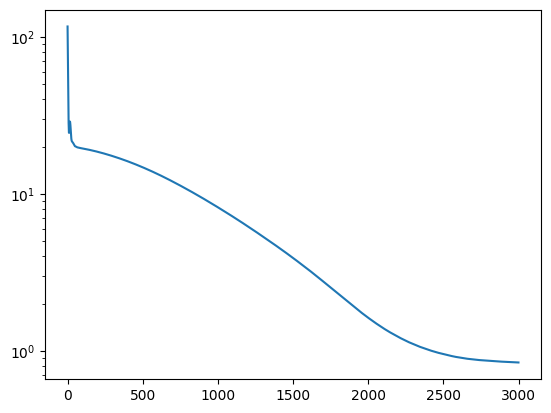

In [133]:
lasso = LASSO().fit(v_obs)
x, hists = lasso.transform(X_obs[:10], a=1e-1, epochs=3000, lr=1e-4)
plt.plot(hists)
plt.yscale('log')

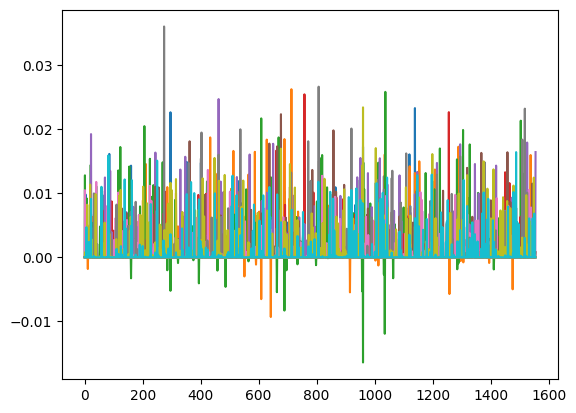

In [134]:
plt.plot(x.numpy().T)

In [135]:
xi[ids]

array([0.03726275, 0.03015177, 0.0292533 , 0.02919805, 0.02709902,
       0.02522829, 0.02282364, 0.01994512, 0.01964886, 0.01942296],
      dtype=float32)

(-0.5, 831.5, 831.5, -0.5)

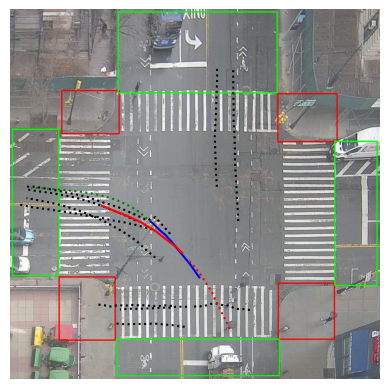

In [136]:
i = 7
xi = x[i].numpy()
ids = np.argsort(np.abs(xi))[::-1][:10]
c = xi[ids].sum()
prd_o = np.dot(v_obs[ids].transpose(1, 2, 0), xi[ids] / c)
prd_p = np.dot(v_prd[ids].transpose(1, 2, 0), xi[ids] / c)
img = plt.imread('test_boxes.jpg')
plt.imshow(img)
plt.plot(v_prd[ids, :, 0].T, v_prd[ids, :, 1].T, 'k:')
plt.plot(X_obs[i, :, 0], X_obs[i, :, 1], 'b')
plt.plot(X_prd[i, :, 0], X_prd[i, :, 1], 'g:')
plt.plot(prd_o[:, 0], prd_o[:, 1], 'r:')
plt.plot(prd_p[:, 0], prd_p[:, 1], 'r')
plt.axis('off')

In [41]:
class Model(nn.Module):
    def __init__(self, dim, D, sparsity=32):
        super().__init__()
        self. = torch.as_tensor(D).reshape(len(D), -1).float()
        self.k = nn.Embedding(len(D), 18)
        self.att_in = nn.MultiheadAttention(18, 1, batch_first=True)
        self.att_dc = nn.MultiheadAttention(18, 1, batch_first=True)
        self.softmax = nn.Softmax(-1)
    def forward(self, y):
        # q
        q = y.reshape(len(y), -1).float()
        k = self.k.weight
        w = self.softmax(q @ self.v.T)
        return w

model = Model(8, v_obs)
x = model(torch.as_tensor(X_obs[:1]))
x

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [42]:
torch.where(x != 0)

(tensor([0]), tensor([977]))

In [44]:
v_obs[977], X_obs[1]

(array([[686.989435 , 821.44255  ],
        [688.023345 , 813.7622   ],
        [688.79757  , 805.466    ],
        [687.686425 , 798.11678  ],
        [688.91142  , 787.6391675],
        [690.8230825, 779.863325 ],
        [689.88495  , 770.623625 ],
        [690.52595  , 761.29483  ],
        [690.4613075, 754.551405 ]]),
 array([[ 86.8700235 , 514.06207   ],
        [102.504135  , 512.537465  ],
        [117.61170125, 512.3398875 ],
        [134.2945325 , 511.01115   ],
        [153.0234325 , 508.3129925 ],
        [167.74132475, 504.026845  ],
        [178.545225  , 499.66588   ],
        [189.34645   , 494.81502   ],
        [203.538     , 490.217835  ]]))